# XGBoost and SHAP plots for RAMAP (blood)

### The first half of this notebook explores predicting disease activity (expressed as high or low) using transcriptomic data.  Shap plots are used to describe which genes are driving the model.  The second part of this notebook, drills down to the genes making up IFN A and IFN B and uses these to predict Responders and Non Responders (response is based on Remission column in the file Clusters.txt

In [1]:
# load libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import shap

In [2]:
# a function that displays the actual value, the predicted value and the disease activity score
# adapted from Max Steele def shap_force 
# https://medium.com/mlearning-ai/shap-force-plots-for-classification-d30be430e195
def shap_accuracy(prediction_list, index, y_values, DA_values):
    pred = prediction_list[index]
    
    true_label = y_values[index]
    
    DA = DA_values[index]
    
    ## Assess accuracy of prediction
    if true_label == pred:
        accurate = 'Correct'
    else:
        accurate = 'Incorrect'
        
    ## Print output that checks model's prediction against true label
    print('***'*12)
    # print ground truth label for row at index
    print(f'Ground Truth Label: {true_label}')
    # Print model prediction for row at index
    print(f'Model Prediction:  {pred} -- {accurate}')
    # print disease activity score
    print(f'Score: {DA}')
    print('***'*12)
    print()

In [3]:
# read in the clinical data and corresponding gene expression data
clin = pd.read_csv('output/phenoRAMAPforSHAP.csv', header = 0, index_col=0)
data = pd.read_csv('output/edataRAMAPforSHAP.csv', header = 0, index_col = 0)
data = data.T

In [4]:
# add DAS28 ranking to clin for the whole dataset
DAS28ranking = clin[['DAS28.0M']]
DAS28ranking['rowPosition'] = DAS28ranking.reset_index().index
DAS28ranking = DAS28ranking.sort_values(by = 'DAS28.0M', ascending = False)
DAS28ranking['DAS28order'] = DAS28ranking.reset_index().index
DAS28ranking2 = DAS28ranking.drop("DAS28.0M", 1)

clin2 = clin.merge(DAS28ranking2, left_index = True, right_index = True) 

# get row position of ranking 0-9
Top10DAS28 = []
for i in range(0,10):
    highest = DAS28ranking2.loc[DAS28ranking2["DAS28order"] == i, "rowPosition"].item()
    Top10DAS28.append(highest)
print("TOP 10 DAS28 rows", Top10DAS28)

start_range = DAS28ranking2.shape[0] - 1 # number of rows
end_range = start_range - 10
print("start_range", start_range)
print("end_range", end_range)

# get row positions for bottom 10
Bot10DAS28 = []
for i in range(start_range,end_range, -1):
    lowest = DAS28ranking2.loc[DAS28ranking2["DAS28order"] == i, "rowPosition"].item()
    Bot10DAS28.append(lowest)
print("BOTTOM 10 DAS28 rows", Bot10DAS28)

TOP 10 DAS28 rows [24, 158, 47, 156, 70, 16, 35, 71, 84, 0]
start_range 168
end_range 158
BOTTOM 10 DAS28 rows [126, 143, 55, 43, 93, 19, 116, 63, 49, 105]



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.


In [5]:
# pre-proc
y =  clin["DiseaseActivityRating"]
X_train, X_test, y_train, y_test = train_test_split(data,
                                                    y,
                                                    stratify = y,
                                                    shuffle = True, 
                                                    test_size = 0.3, 
                                                    random_state = 132)   

print("X_train shape", X_train.shape)
print("X_test shape", X_test.shape)
print("data shape", data.shape)

X_train shape (118, 17625)
X_test shape (51, 17625)
data shape (169, 17625)


In [6]:
# train the model
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)
param = {'max_depth': 2, 
    'eta': 0.2,                           #  these have to be optimised for your model
        'objective': 'binary:logistic',   #  this depends on the nature of your model
        #'scale_pos_weight':5
        }             #  this depends on your classes

param['eval_metric'] = 'auc'
num_round = 100
evallist = [(dtest, 'eval'),(dtrain, 'train')] # eval test
progress = {}
model = xgb.train(param, dtrain, num_round, 
                     evallist, evals_result = progress, 
                     verbose_eval=10, 
                     early_stopping_rounds=25) 

# classes in y_test
print(" ")
print("bincount y_test:", np.bincount(y_test))

Pass `evals` as keyword args.  Passing these as positional arguments will be considered as error in future releases.


[0]	eval-auc:0.54270	train-auc:0.87269
[10]	eval-auc:0.63043	train-auc:1.00000
[20]	eval-auc:0.66770	train-auc:1.00000
[30]	eval-auc:0.65994	train-auc:1.00000
[31]	eval-auc:0.66149	train-auc:1.00000
 
bincount y_test: [23 28]


In [7]:
# preds
preds = model.predict(dtest)
prediction =[]
for i in preds:
    if i >=0.5:
        prediction.append(1)
    else:
        prediction.append(0)
print(np.bincount(prediction))

[20 31]


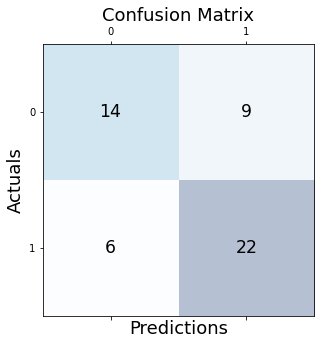

In [8]:
# calculate the confusion matrix
conf_matrix = confusion_matrix(y_true = y_test, y_pred = prediction)

# Print the confusion matrix using Matplotlib
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [9]:
# scores
print('Precision: %.3f' % precision_score(y_test, prediction))
print('Recall: %.3f' % recall_score(y_test, prediction))
print('Accuracy: %.3f' % accuracy_score(y_test, prediction))
print('F1 Score: %.3f' % f1_score(y_test, prediction))
precision_recall_fscore_support(y_test, prediction)

Precision: 0.710
Recall: 0.786
Accuracy: 0.706
F1 Score: 0.746


(array([0.7       , 0.70967742]),
 array([0.60869565, 0.78571429]),
 array([0.65116279, 0.74576271]),
 array([23, 28]))

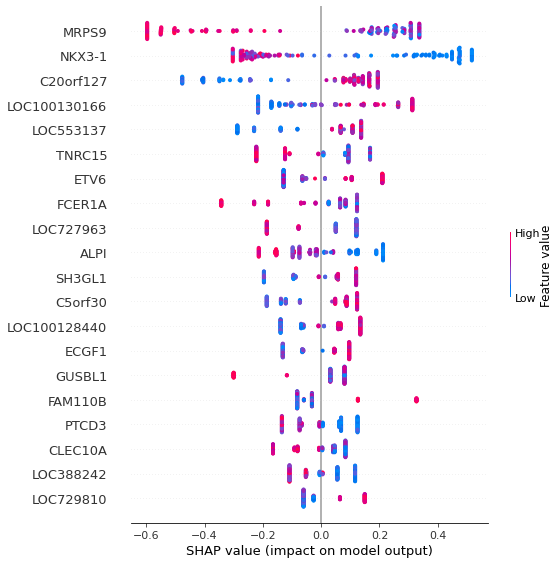

In [10]:
# calculate the shap values for the whole dataset
shap.initjs

shap_values = shap.TreeExplainer(model).shap_values(data)  

# print the shap summary plot
shap.summary_plot(shap_values, data, feature_names=data.columns) 

In [11]:
# prep for force plots using the whole dataset
explainer = shap.TreeExplainer(model, data)
base_value = explainer.expected_value
#shap.force_plot(base_value, shap_values[12,:], df_.iloc[12,:], plot_cmap="PkYg")

features = list(data.columns)

# convert data DF to array
data_ = data.to_numpy()

# run predictions for the whole dataset
d_data = xgb.DMatrix(data, label=y)

preds_data = model.predict(d_data)
prediction_data =[]
for i in preds_data:
    if i >=0.5:
        prediction_data.append(1)
    else:
        prediction_data.append(0)

# disease activity scores into a series        
DAS28_0M = clin[['DAS28.0M']]
DAS28_0M = DAS28_0M.to_numpy()

************************************
Ground Truth Label: 1
Model Prediction:  1 -- Correct
Score: [8.68]
************************************



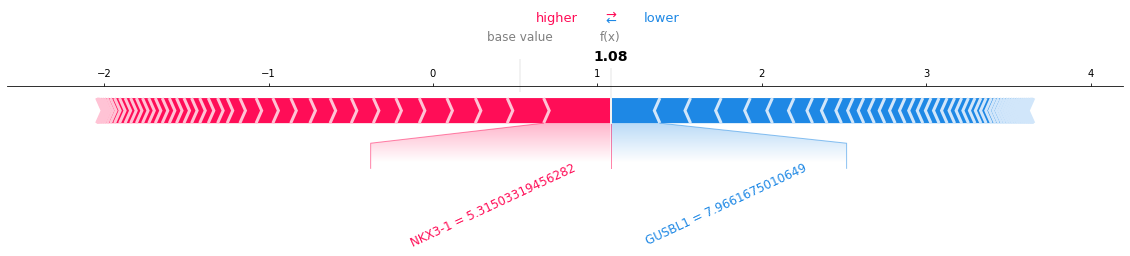

************************************
Ground Truth Label: 1
Model Prediction:  1 -- Correct
Score: [8.14]
************************************



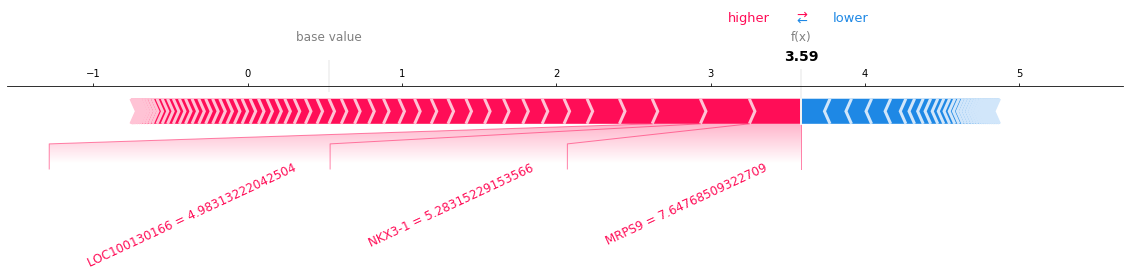

************************************
Ground Truth Label: 1
Model Prediction:  1 -- Correct
Score: [7.95]
************************************



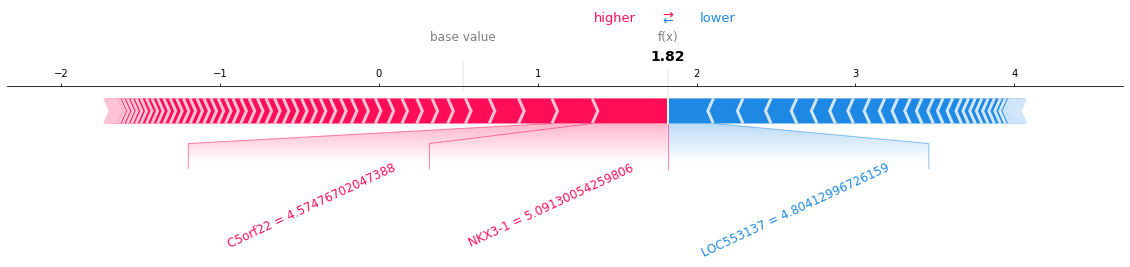

************************************
Ground Truth Label: 1
Model Prediction:  1 -- Correct
Score: [7.87]
************************************



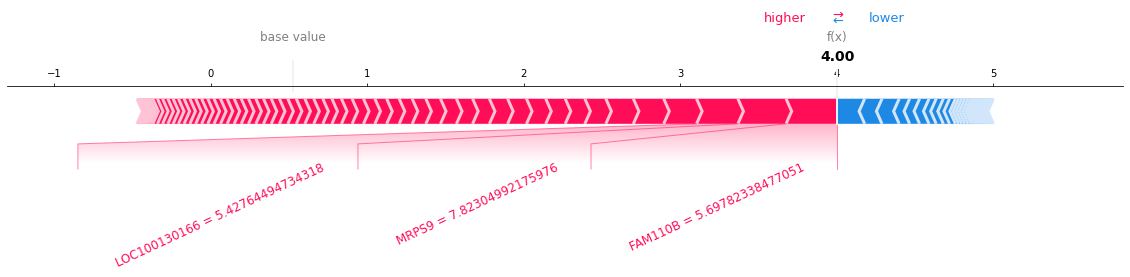

************************************
Ground Truth Label: 1
Model Prediction:  1 -- Correct
Score: [7.72]
************************************



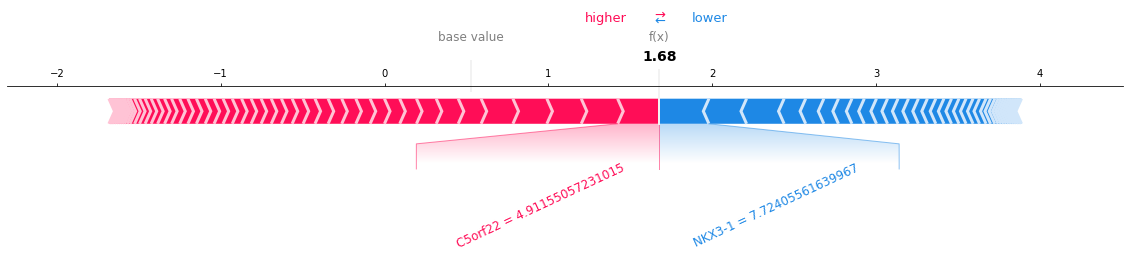

************************************
Ground Truth Label: 1
Model Prediction:  1 -- Correct
Score: [7.58]
************************************



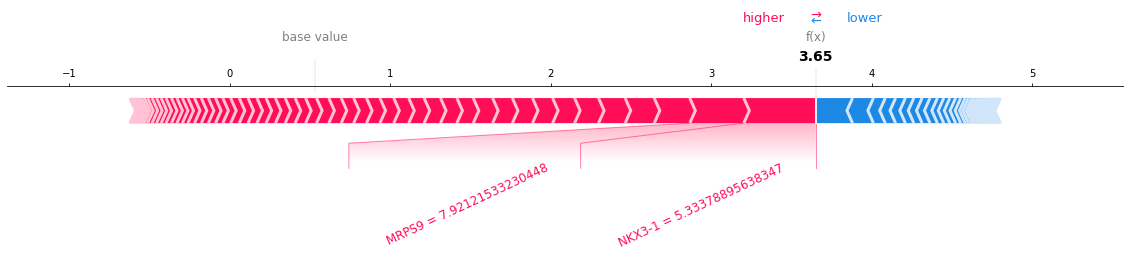

************************************
Ground Truth Label: 1
Model Prediction:  1 -- Correct
Score: [7.58]
************************************



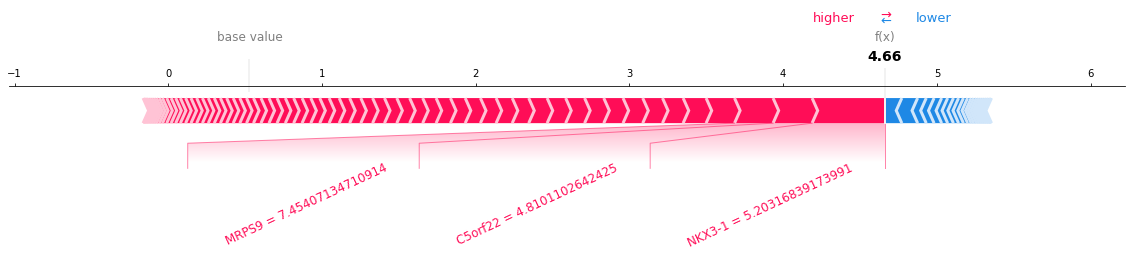

************************************
Ground Truth Label: 1
Model Prediction:  0 -- Incorrect
Score: [7.52]
************************************



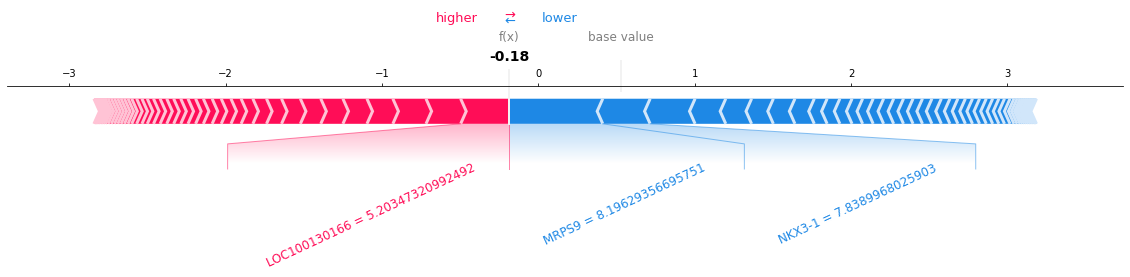

************************************
Ground Truth Label: 1
Model Prediction:  1 -- Correct
Score: [7.51]
************************************



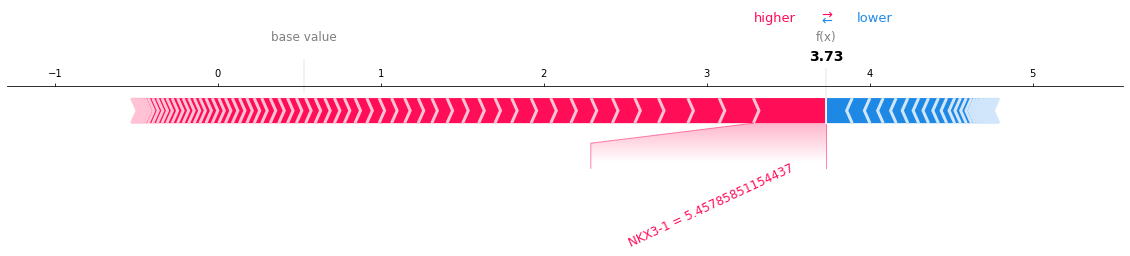

************************************
Ground Truth Label: 1
Model Prediction:  1 -- Correct
Score: [7.42]
************************************



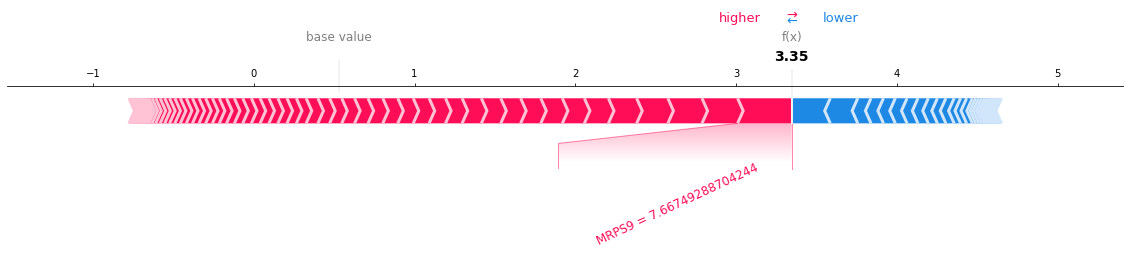

In [12]:
# force plots for highest 10 disease activity scores
for i in Top10DAS28:
    #print(i)
    shap_accuracy(prediction_data, i, y, DAS28_0M)
    shap.force_plot(base_value, shap_values[i], data_[i], feature_names = features,
                matplotlib = True, plot_cmap="PkYg", text_rotation = 25)


************************************
Ground Truth Label: 0
Model Prediction:  0 -- Correct
Score: [2.07]
************************************



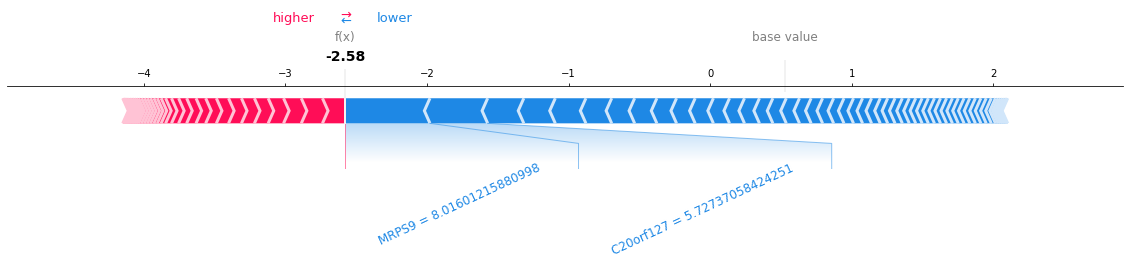

************************************
Ground Truth Label: 0
Model Prediction:  0 -- Correct
Score: [2.23]
************************************



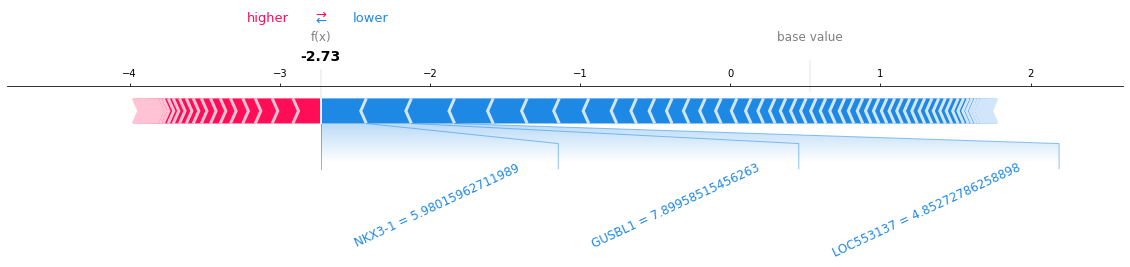

************************************
Ground Truth Label: 0
Model Prediction:  0 -- Correct
Score: [2.23]
************************************



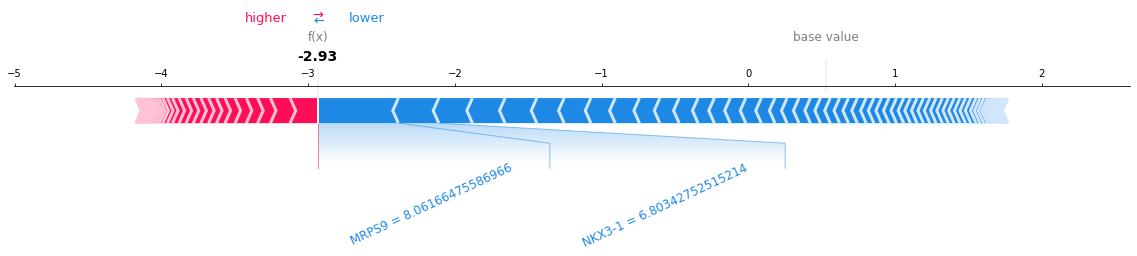

************************************
Ground Truth Label: 0
Model Prediction:  0 -- Correct
Score: [2.43]
************************************



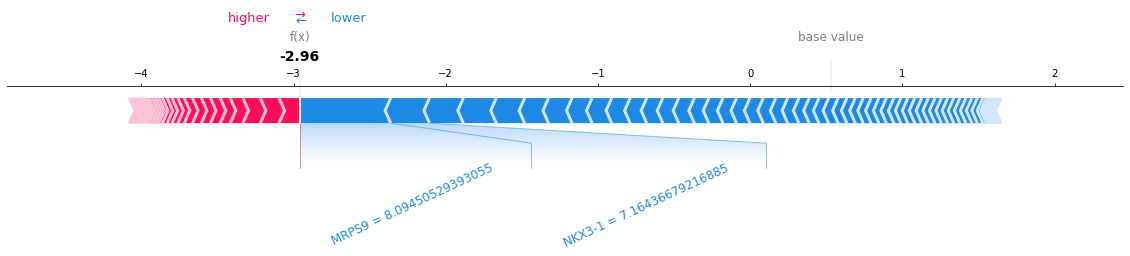

************************************
Ground Truth Label: 0
Model Prediction:  1 -- Incorrect
Score: [2.44]
************************************



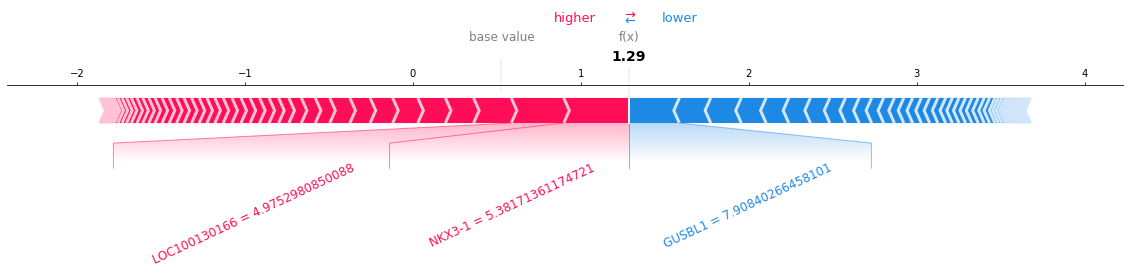

************************************
Ground Truth Label: 0
Model Prediction:  0 -- Correct
Score: [2.64]
************************************



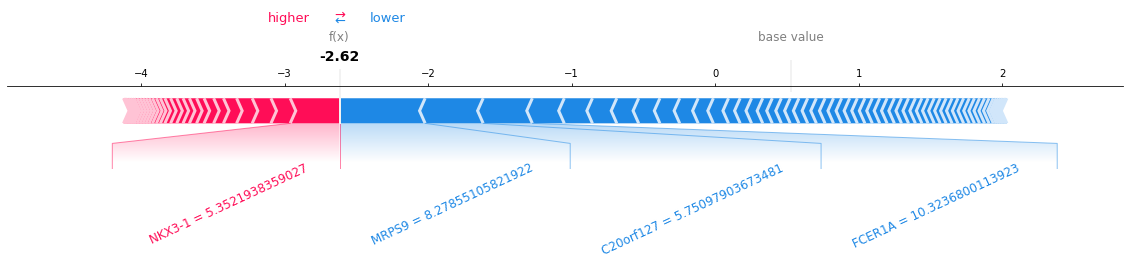

************************************
Ground Truth Label: 0
Model Prediction:  0 -- Correct
Score: [2.7]
************************************



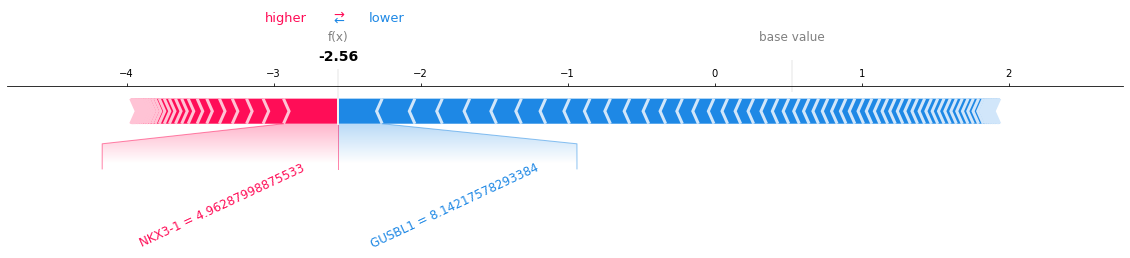

************************************
Ground Truth Label: 0
Model Prediction:  0 -- Correct
Score: [2.73]
************************************



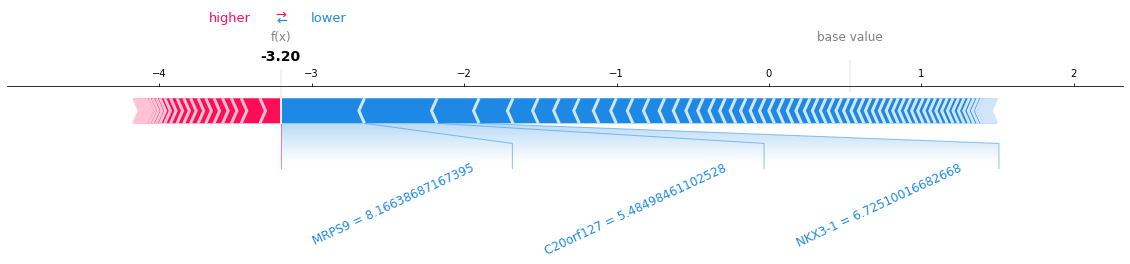

************************************
Ground Truth Label: 0
Model Prediction:  0 -- Correct
Score: [2.76]
************************************



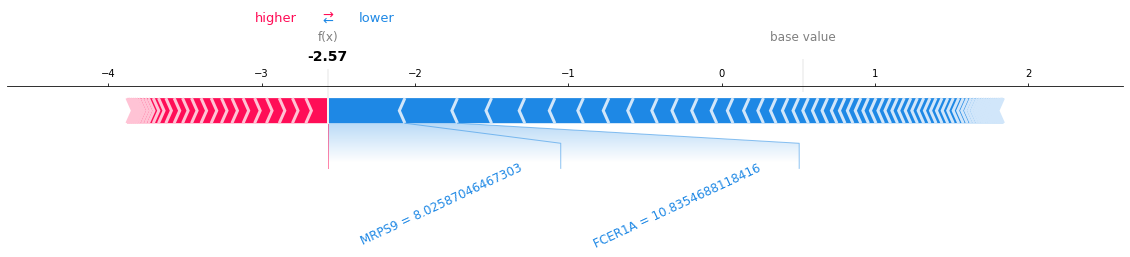

************************************
Ground Truth Label: 0
Model Prediction:  0 -- Correct
Score: [2.77]
************************************



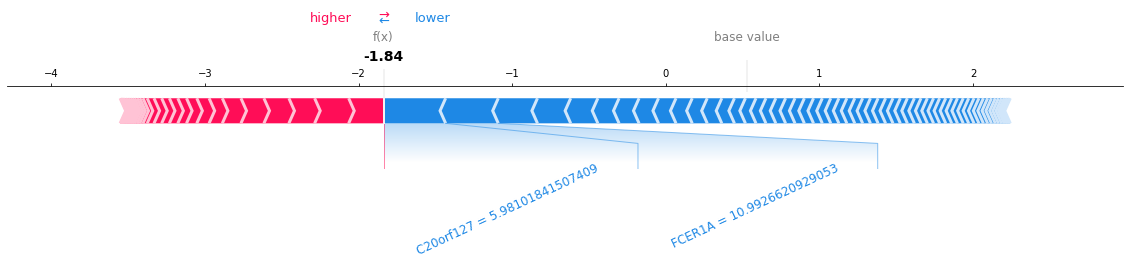

In [13]:
# force plots for lowest 10 disease activity scores
for i in Bot10DAS28:
    #print(i)
    shap_accuracy(prediction_data, i, y, DAS28_0M)
    shap.force_plot(base_value, shap_values[i], data_[i], feature_names = features,
                matplotlib = True, plot_cmap="PkYg", text_rotation = 25)


## Interferon Genes

In [14]:
# load the interferon datasets
IFNclin = pd.read_csv('output/IFNphenoRAMAPforSHAP.csv', header = 0, index_col=0)
IFNdata = pd.read_csv('output/IFNedataRAMAPforSHAP.csv', header = 0, index_col = 0)
IFNdata = IFNdata.T

In [15]:
# add delta disease activity ranking to IFNclin
# Use DeltaDAS28
DeltaDAranking = IFNclin[['DeltaDAS28']]
DeltaDAranking['DeltarowPosition'] = DeltaDAranking.reset_index().index
DeltaDAranking = DeltaDAranking.sort_values(by = 'DeltaDAS28', ascending = False)
DeltaDAranking['DeltaDAorder'] = DeltaDAranking.reset_index().index
DeltaDAranking2 = DeltaDAranking.drop("DeltaDAS28", 1)

IFNclin = IFNclin.merge(DeltaDAranking2, left_index = True, right_index = True) 

# get row position of ranking 0-9
Top10DeltaDA = []
for i in range(0,10):
    highestDelta = DeltaDAranking2.loc[DeltaDAranking2["DeltaDAorder"] == i, "DeltarowPosition"].item()
    Top10DeltaDA.append(highestDelta)
print("TOP 10 Delta DA rows", Top10DeltaDA)

start_rangeIFN = DeltaDAranking2.shape[0] - 1 # number of rows
end_rangeIFN = start_rangeIFN - 10
print("start_range", start_rangeIFN)
print("end_range", end_rangeIFN)

# get row positions for bottom 10
Bot10DeltaDA = []
for i in range(start_rangeIFN, end_rangeIFN, -1):
    lowestDelta = DeltaDAranking2.loc[DeltaDAranking2["DeltaDAorder"] == i, "DeltarowPosition"].item()
    Bot10DeltaDA.append(lowestDelta)
print("BOTTOM 10 Delta DA rows", Bot10DeltaDA)

TOP 10 Delta DA rows [51, 7, 17, 69, 66, 80, 72, 26, 28, 58]
start_range 82
end_range 72
BOTTOM 10 Delta DA rows [10, 44, 9, 60, 63, 25, 81, 82, 71, 57]



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.


In [16]:
# pre-proc
yIFN =  IFNclin["Responder"]
X_trainIFN, X_testIFN, y_trainIFN, y_testIFN = train_test_split(IFNdata,
                                                                yIFN,
                                                                stratify = yIFN,
                                                                shuffle = True, 
                                                                test_size = 0.3, 
                                                                random_state = 132) 
print("X_trainIFN shape", X_trainIFN.shape)
print("X_testIFN shape", X_testIFN.shape)
print("dataIFN shape", IFNdata.shape)

X_trainIFN shape (58, 25)
X_testIFN shape (25, 25)
dataIFN shape (83, 25)


In [17]:
# train the model
dtrainIFN = xgb.DMatrix(X_trainIFN, label=y_trainIFN)
dtestIFN = xgb.DMatrix(X_testIFN, label=y_testIFN)
paramIFN = {'max_depth': 2, 
    'eta': 0.2,                           #  these have to be optimised for your model
        'objective': 'binary:logistic',   #  this depends on the nature of your model
        #'scale_pos_weight':5
        }             #  this depends on your classes

paramIFN['eval_metric'] = 'auc'
num_roundIFN = 100
evallistIFN = [(dtestIFN, 'eval'),(dtrainIFN, 'train')] # eval test
progressIFN = {}
modelIFN = xgb.train(paramIFN, dtrainIFN, num_roundIFN, 
                     evallistIFN, evals_result = progressIFN, 
                     verbose_eval=10, 
                     early_stopping_rounds=25) 

# classes in y_test
print(" ")
print("bincount y_test:", np.bincount(y_testIFN))

[0]	eval-auc:0.53526	train-auc:0.80000
[10]	eval-auc:0.59295	train-auc:0.99643
[20]	eval-auc:0.57051	train-auc:1.00000


Pass `evals` as keyword args.  Passing these as positional arguments will be considered as error in future releases.


[30]	eval-auc:0.52564	train-auc:1.00000
[36]	eval-auc:0.50000	train-auc:1.00000
 
bincount y_test: [13 12]


In [18]:
# preds
predsIFN = modelIFN.predict(dtestIFN)
predictionIFN =[]
for i in predsIFN:
    if i >=0.5:
        predictionIFN.append(1)
    else:
        predictionIFN.append(0)
print(np.bincount(predictionIFN))

[10 15]


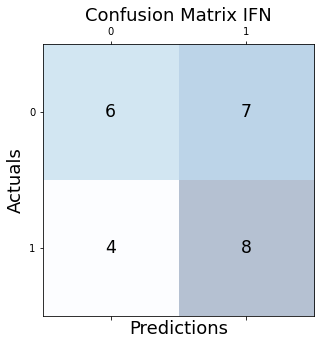

In [19]:
conf_matrixIFN = confusion_matrix(y_true = y_testIFN, y_pred = predictionIFN)

# Print the confusion matrix using Matplotlib
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrixIFN, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrixIFN.shape[0]):
    for j in range(conf_matrixIFN.shape[1]):
        ax.text(x=j, y=i,s=conf_matrixIFN[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix IFN', fontsize=18)
plt.show()

In [20]:
# scores
print('Precision: %.3f' % precision_score(y_testIFN, predictionIFN))
print('Recall: %.3f' % recall_score(y_testIFN, predictionIFN))
print('Accuracy: %.3f' % accuracy_score(y_testIFN, predictionIFN))
print('F1 Score: %.3f' % f1_score(y_testIFN, predictionIFN))
precision_recall_fscore_support(y_testIFN, predictionIFN)

Precision: 0.533
Recall: 0.667
Accuracy: 0.560
F1 Score: 0.593


(array([0.6       , 0.53333333]),
 array([0.46153846, 0.66666667]),
 array([0.52173913, 0.59259259]),
 array([13, 12]))

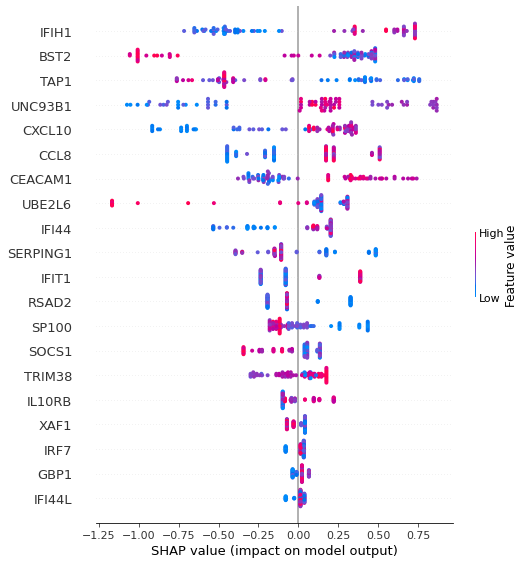

In [21]:
# calculate the shap values for the whole dataset
shap.initjs()

shap_valuesIFN = shap.TreeExplainer(modelIFN).shap_values(IFNdata)  

# print the shap summary plot
shap.summary_plot(shap_valuesIFN, IFNdata, feature_names=IFNdata.columns) 

In [22]:
# prep for force plots using the IFN dataset
explainerIFN = shap.TreeExplainer(modelIFN, IFNdata)
expected_valueIFN = explainerIFN.expected_value

featuresIFN = list(IFNdata.columns)

# convert data DF to array
IFNdata_ = IFNdata.to_numpy()

# run predictions for the IFN dataset
d_IFNdata = xgb.DMatrix(IFNdata, label=yIFN)

preds_dataIFN = modelIFN.predict(d_IFNdata)
prediction_dataIFN =[]
for i in preds_dataIFN:
    if i >=0.5:
        prediction_dataIFN.append(1)
    else:
        prediction_dataIFN.append(0)

# delta disease activity scores into a series        
DeltaDA = IFNclin[['DeltaDAS28']]
DeltaDA = DeltaDA.to_numpy()

In [23]:
shap.force_plot(expected_valueIFN, shap_valuesIFN, IFNdata)

************************************
Ground Truth Label: 1
Model Prediction:  1 -- Correct
Score: [5.66]
************************************



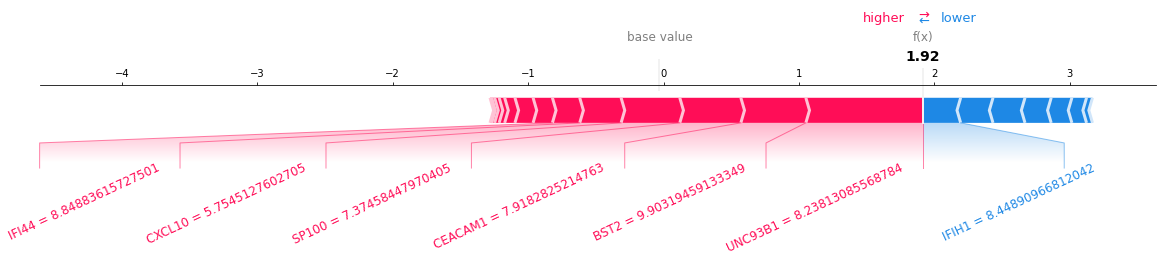

************************************
Ground Truth Label: 1
Model Prediction:  1 -- Correct
Score: [5.54]
************************************



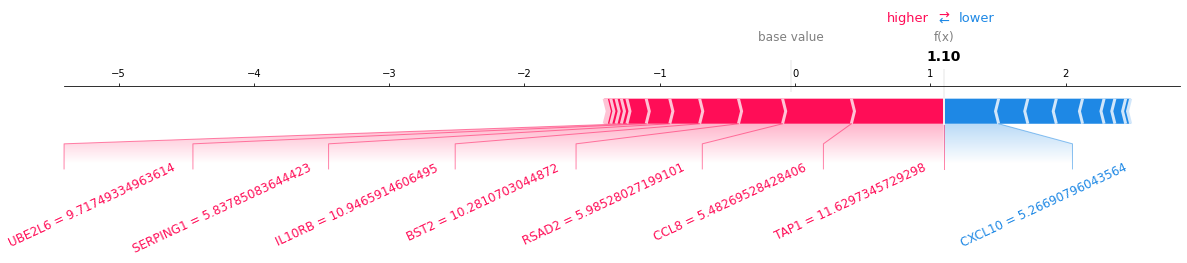

************************************
Ground Truth Label: 1
Model Prediction:  1 -- Correct
Score: [5.35]
************************************



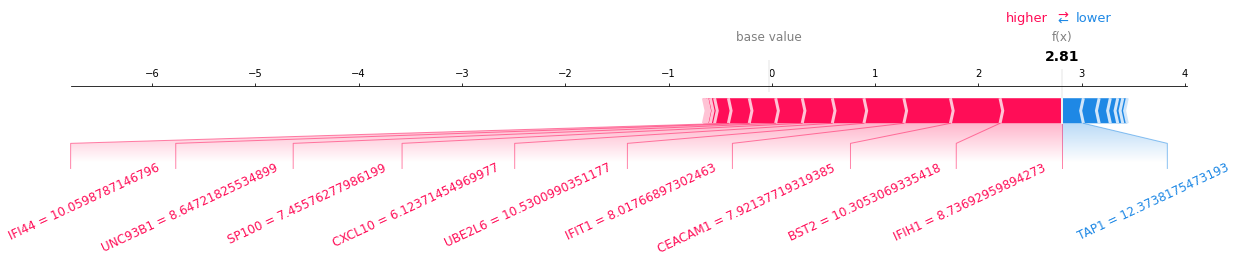

************************************
Ground Truth Label: 1
Model Prediction:  1 -- Correct
Score: [4.9]
************************************



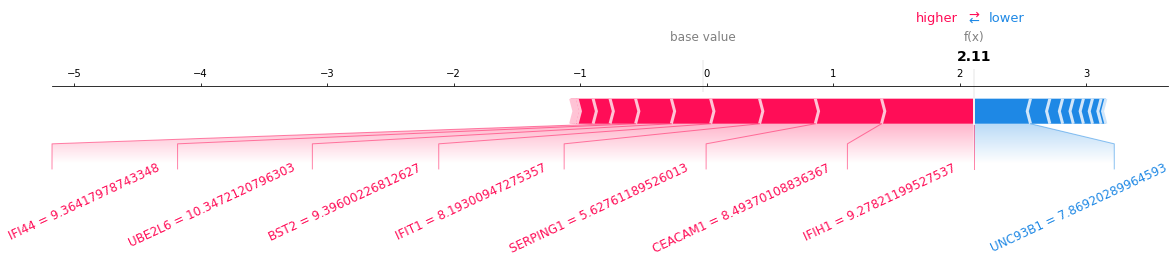

************************************
Ground Truth Label: 1
Model Prediction:  1 -- Correct
Score: [4.49]
************************************



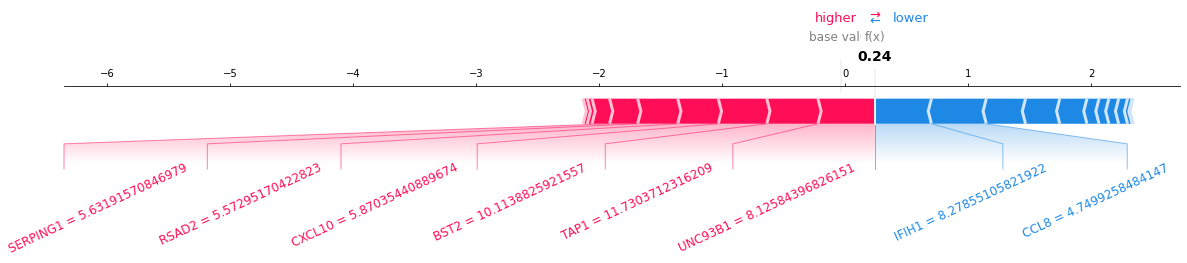

************************************
Ground Truth Label: 1
Model Prediction:  1 -- Correct
Score: [4.48]
************************************



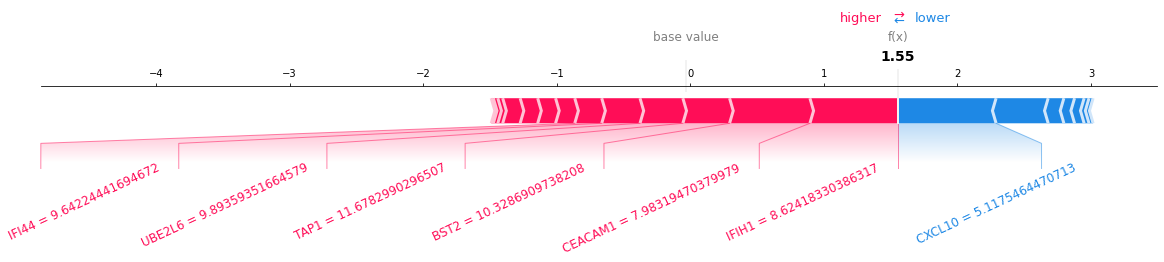

************************************
Ground Truth Label: 1
Model Prediction:  1 -- Correct
Score: [4.46]
************************************



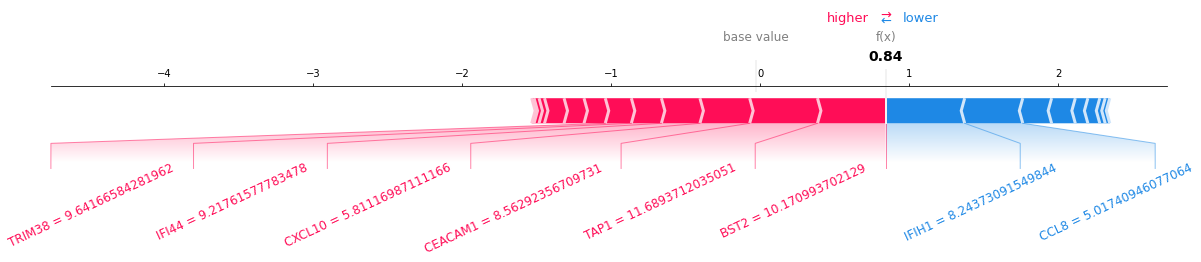

************************************
Ground Truth Label: 1
Model Prediction:  1 -- Correct
Score: [4.4]
************************************



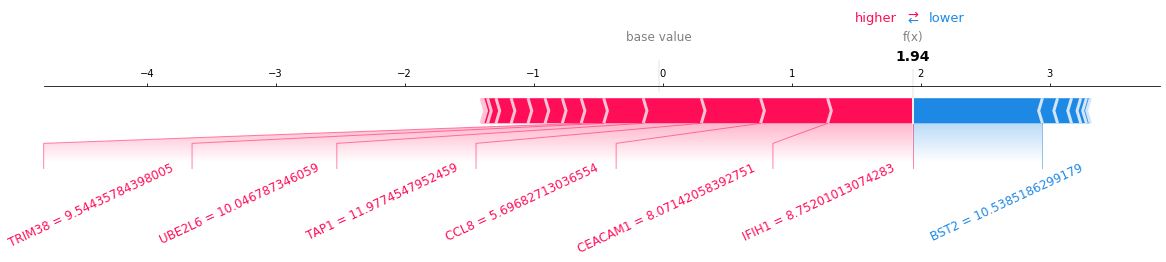

************************************
Ground Truth Label: 1
Model Prediction:  1 -- Correct
Score: [4.33]
************************************



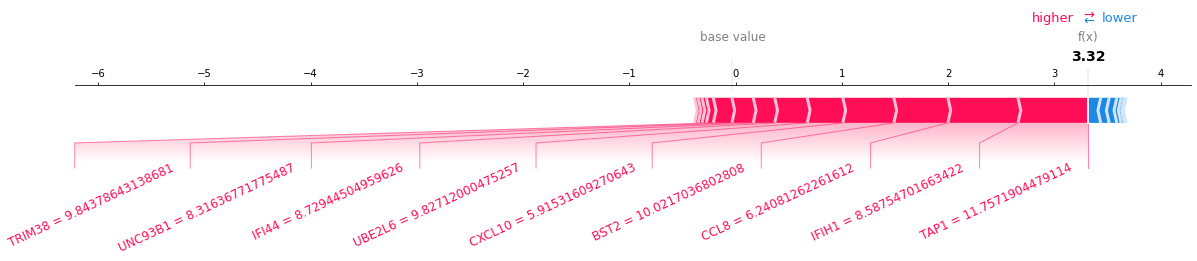

************************************
Ground Truth Label: 1
Model Prediction:  0 -- Incorrect
Score: [4.25]
************************************



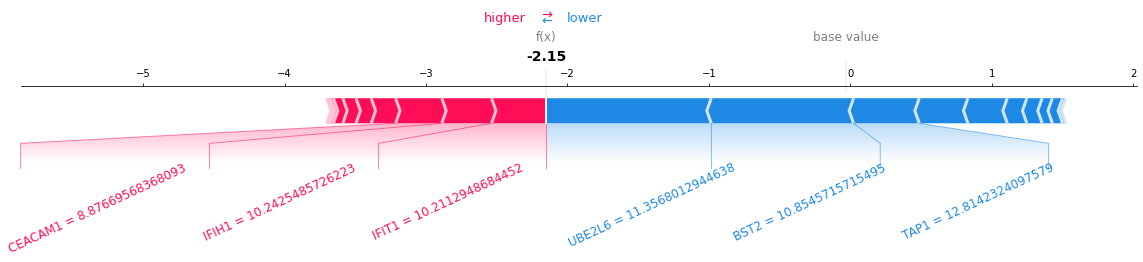

In [24]:
# force plots for highest 10 delta disease activity scores
for i in Top10DeltaDA:
    #print(i)
    shap_accuracy(prediction_dataIFN, i, yIFN, DeltaDA)
    shap.force_plot(expected_valueIFN, shap_valuesIFN[i], IFNdata_[i], feature_names = featuresIFN,
                matplotlib = True, plot_cmap="PkYg", text_rotation = 25)

************************************
Ground Truth Label: 0
Model Prediction:  0 -- Correct
Score: [-2.07]
************************************



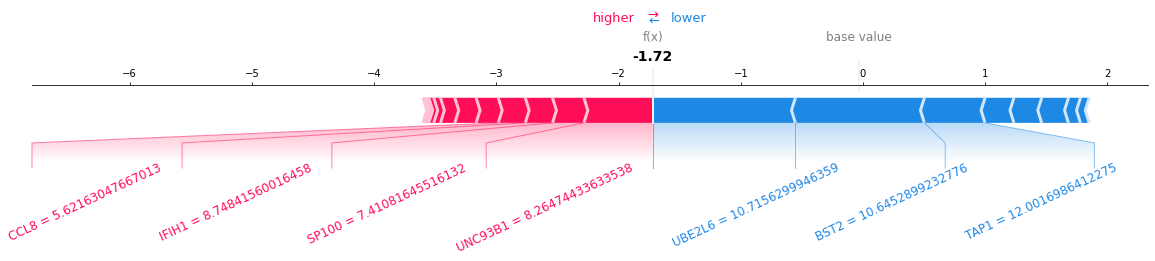

************************************
Ground Truth Label: 0
Model Prediction:  0 -- Correct
Score: [-1.57]
************************************



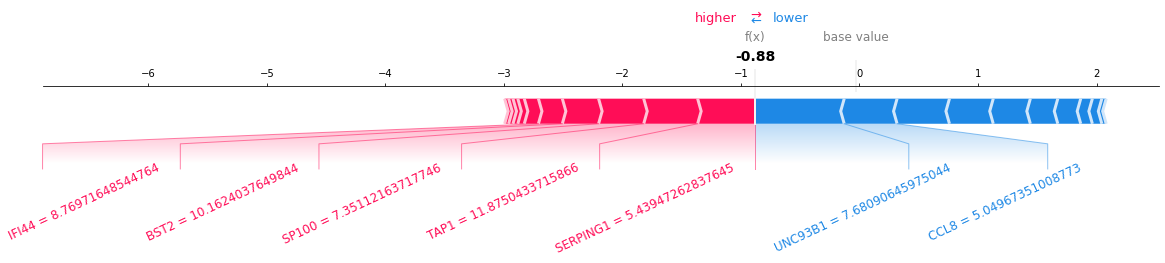

************************************
Ground Truth Label: 0
Model Prediction:  0 -- Correct
Score: [-1.09]
************************************



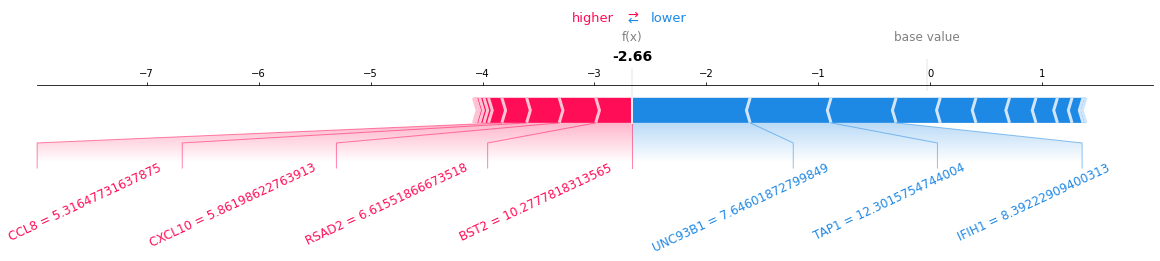

************************************
Ground Truth Label: 0
Model Prediction:  1 -- Incorrect
Score: [-0.79]
************************************



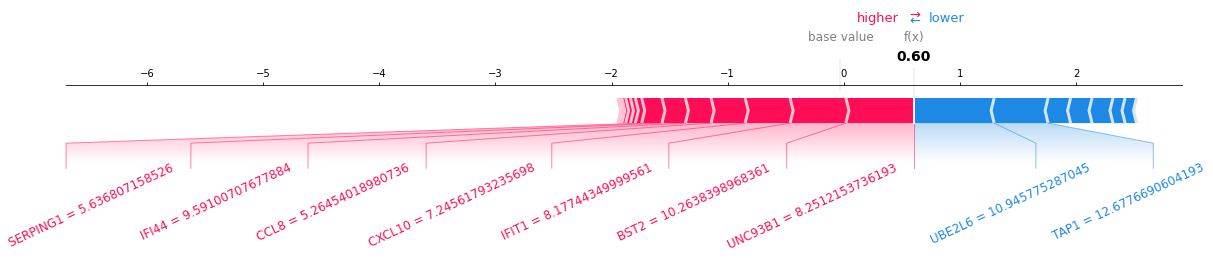

************************************
Ground Truth Label: 0
Model Prediction:  0 -- Correct
Score: [-0.78]
************************************



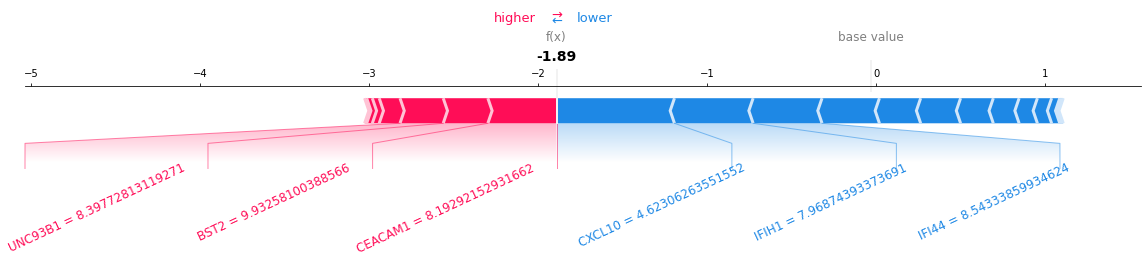

************************************
Ground Truth Label: 0
Model Prediction:  0 -- Correct
Score: [-0.74]
************************************



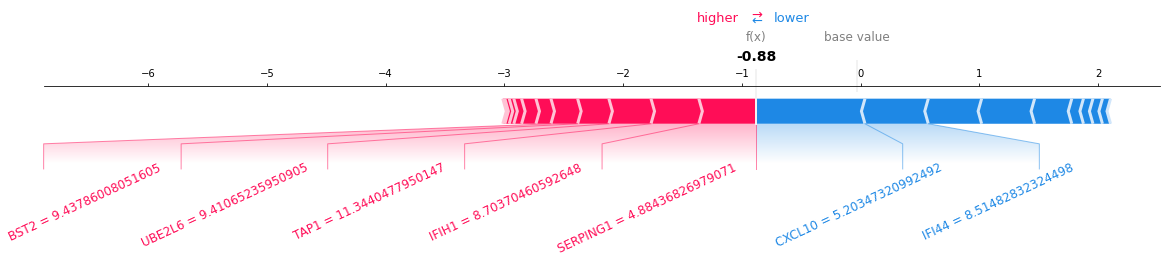

************************************
Ground Truth Label: 0
Model Prediction:  0 -- Correct
Score: [-0.67]
************************************



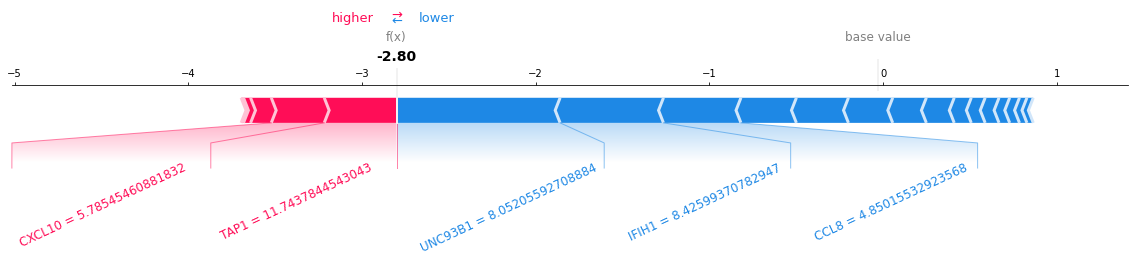

************************************
Ground Truth Label: 0
Model Prediction:  0 -- Correct
Score: [-0.6]
************************************



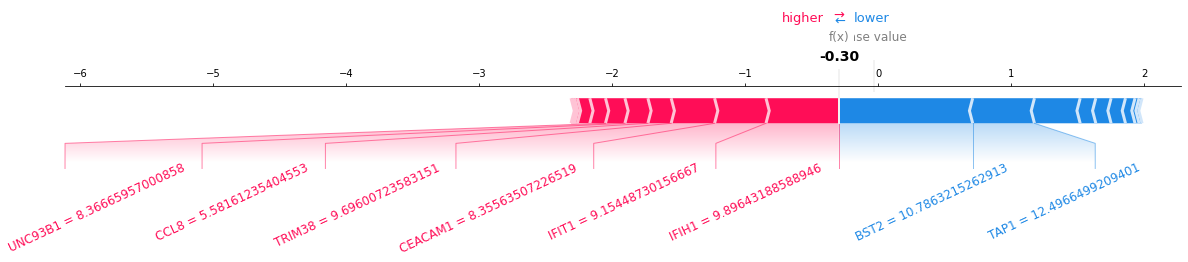

************************************
Ground Truth Label: 0
Model Prediction:  1 -- Incorrect
Score: [-0.4]
************************************



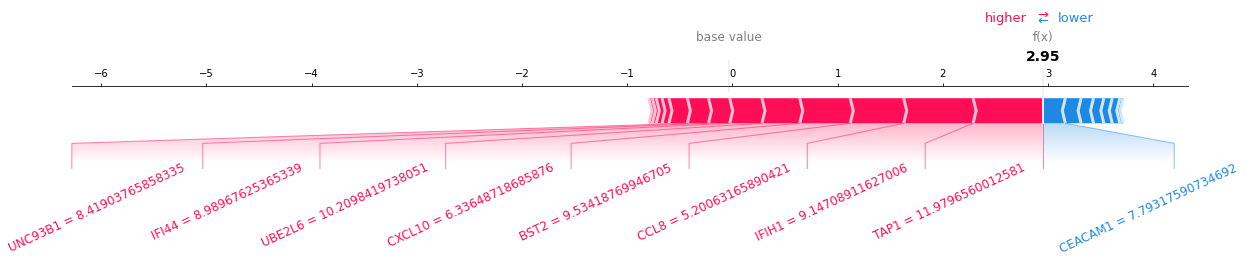

************************************
Ground Truth Label: 0
Model Prediction:  0 -- Correct
Score: [-0.3]
************************************



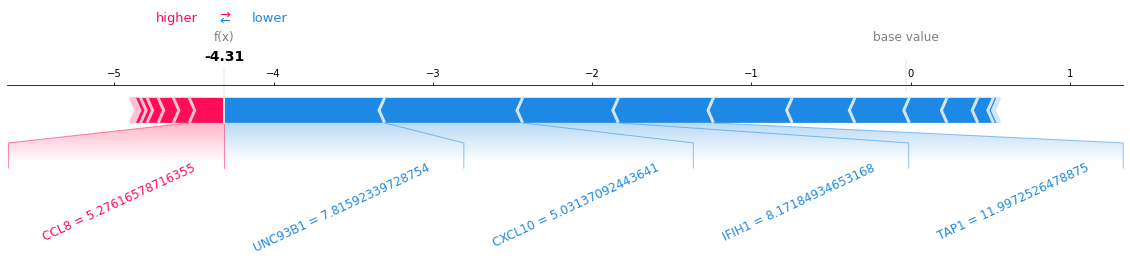

In [25]:
# force plots for lowest 10 delta disease activity scores
for i in Bot10DeltaDA:
    #print(i)
    shap_accuracy(prediction_dataIFN, i, yIFN, DeltaDA)
    shap.force_plot(expected_valueIFN, shap_valuesIFN[i], IFNdata_[i], feature_names = featuresIFN,
                matplotlib = True, plot_cmap="PkYg", text_rotation = 25)


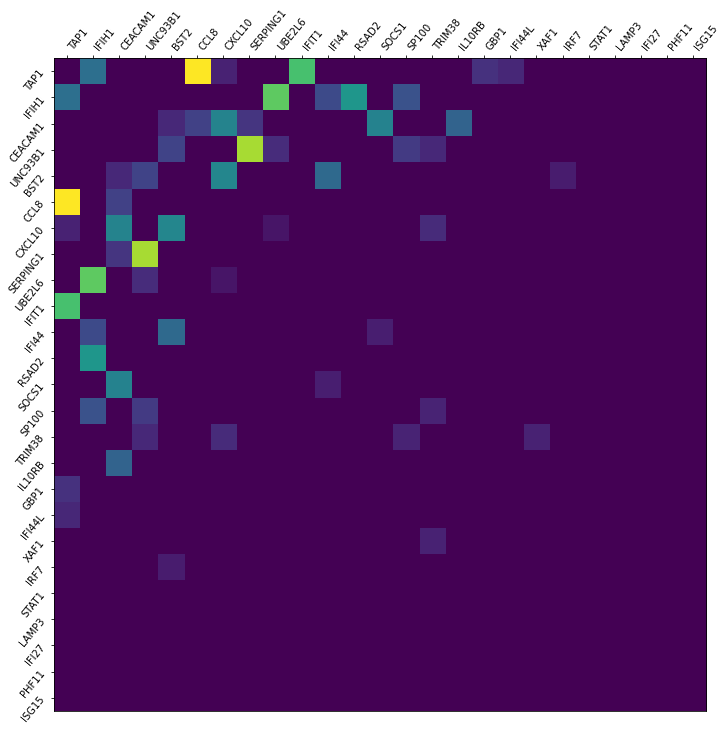

In [26]:
import matplotlib.pylab as pl

shap_interaction_valuesIFN = shap.TreeExplainer(modelIFN).shap_interaction_values(IFNdata)

tmp = np.abs(shap_interaction_valuesIFN).sum(0)
for i in range(tmp.shape[0]):
    tmp[i,i] = 0
inds = np.argsort(-tmp.sum(0))[:50]
tmp2 = tmp[inds,:][:,inds]
pl.figure(figsize=(12,12))
pl.imshow(tmp2)
pl.yticks(range(tmp2.shape[0]), IFNdata.columns[inds], rotation=50.4, horizontalalignment="right")
pl.xticks(range(tmp2.shape[0]), IFNdata.columns[inds], rotation=50.4, horizontalalignment="left")
pl.gca().xaxis.tick_top()
pl.show()